### Simulated Heavy-Ion Collisions with a Generative Adversarial Network

Certain physics models to describe the initially deposited energy density in heavy-ion collisions can be computationally demanding, with the generation of a single event exceeding several core hours. 

These notebooks explore the use of Generative Adversarial Networks (GAN) as a fast and approximate surrogate to model the collision initial conditions. 

Please see this page for a useful introduction to GANs: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/ and https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/ for Wasserstein GANs.

### Before running this notebook, one needs to download the event files.
These occupy quite a bit of space and can not be stored on github. 

Please execute `sh prepare.sh` exactly once before running this analysis notebook. 

In [1]:
#! sh prepare.sh #it will take quite a few minutes to download and decompress the events

The downloaded profiles are stored in the `training_profiles` directory.

They have a format which can be read using the function defined below.

Any work which makes reference to this notebook should cite the authors/generators of the profiles:

B. Schenke, P. Tribedy, R. Venugopalan, Fluctuating Glasma Initial Conditions and Flow in Heavy Ion Collisions
Phys. Rev. Lett. 108, 252301 (2012)

B. Schenke, P. Tribedy, R. Venugopalan
Event-by-event gluon multiplicity, energy density, and eccentricities in ultrarelativistic heavy-ion collisions
Phys. Rev. C86, 034908 (2012)

Please see https://quark.phy.bnl.gov/~bschenke/ipglasma-doc.txt for the documentation. 

We begin by importing some necessary libraries...

In [2]:
#Begin by importing some necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage import filters
#from eccentricities import calc_ecc
from wgan import *

sns.set()
sns.set_context('talk')
sns.set_style("darkgrid", {'axes.grid' : False})

%load_ext cython

Using TensorFlow backend.
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/PAS0254/osu9790/.local/lib/p

The cell below defines a function to read in each profile from disk.

Events belong to different centrality classes, either $0-10$%, $10-20$%, $20-30$% or $30-40$%.

The class for which the WGAN is trained is fixed by the `cent_str` argument.

In [3]:
header_list = ['eta', 'x', 'y', 'eps', 'ut', 'ux', 'uy', 'T00', 'T0x', 'T0y', 'T0eta'] 
nx = ny = 200 # the number of pixels (gridpoints) in x and y
dx = dy = 0.17 # the size of each pixel in fm = 10^{-15} m
n_profiles = 3970 # the number of profiles

# the factor by which we coarse-grain.
# profiles should probably only be coarse-grained for testing/debugging purposes
n_coarse = 1
# the number of pixels to clip off edges
n_clip = 44 

def load_ipglasma_profile(i, cent_str='0-10'):
    """A function to read in a single ipglasma event profile from disk. 
    By default cent_str='0-10' loads training events from the 0-10% most
    central events."""
    df = pd.read_csv('training_profiles/PbPb'+cent_str+'/epsilon-u-Hydro'+str(i)+'.dat', header=None, 
                 sep=' ', skiprows=1, names=header_list)
    eps = df['eps'].values.reshape(nx, ny)[n_clip:-n_clip:n_coarse, n_clip:-n_clip:n_coarse]
    return eps

Let's load and visualize a randomly selected energy density profile.

/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  """


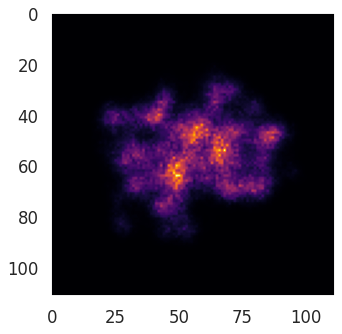

In [4]:
i = np.random.randint(0, high=n_profiles, size=1, dtype='l')[0]
eps = load_ipglasma_profile(i) # the loaded profile
fig, axes = plt.subplots(1,1, figsize=(5,5))
plt.imshow(eps, cmap='inferno')
plt.tight_layout(True)
plt.show()

Typically machine learning models will expect the inputs to be of 'natural' size, not too much smaller or larger than 1. 

Therefore, we will first rescale all of the profiles from $(0, \epsilon_{\rm max}) \rightarrow (-1, 1)$.

The choice of the scaling function may be important in the accuracy of the resulting model, and should likely be explored.

In [5]:
def global_scaler(X):
    scale = X.max()
    X = 2.*X/scale - 1.
    return X, scale

def inv_global_scaler(X, eps_max):
    X = eps_max*(X + 1.)/2.
    return X

Additionally, there is strong evidence that the soft observables in heavy ion collisions are insensitive to small (roughly the pixel size $0.17$ fm) scale geometrical features. 

Concordantly, to improve the behavior of our model, we will first apply a Gaussian smoothing filter to each training profile. See Refs.(https://inspirehep.net/literature/1387518, https://arxiv.org/pdf/1712.03912.pdf) for justification. 


The cell below will iteratively load each profile from disk, apply the Guassian filter to smoothen it.

All the profiles rescaled such that maximum energy density value in the entire ensemble is 1.

In [6]:
# this cell will load each profile from disk, rescale it, apply a smoothing filter
# and append it to the training array

#choose the centrality of events
cent_str='0-10'

#this switch needs to be True if changes are made to the training data, 
#e.g. switching the centrality class, the rescaling function, etc...
regen_training_profiles = False

# the pixel size of the Gauss. filter std. dev. in units of dx
sigma_filter = 2

if regen_training_profiles:
    trainX = [] # array of all training images
    for i in range(1, n_profiles+1):
    #for i in range(1, 100):
        eps_profile = load_ipglasma_profile(i, cent_str=cent_str) #load profile
        #eps_scaled = eps_rescaling_fct(eps_profile, eps_max) #rescale 
        eps_scaled = eps_profile
        eps_smooth = filters.gaussian(eps_scaled, 
                                              sigma=sigma_filter, 
                                              preserve_range=True) #smoothen 
        trainX.append(eps_smooth) #append to training array
    
    trainX = np.array(trainX) #np arrays are nicer
    trainX, eps_max = global_scaler(trainX)
    print(trainX.shape)
    #save the training data to disk, for later convenience
    np.save('training_profiles/trainX', trainX)
    np.save('training_profiles/trainX_eps_max', eps_max)

If the operation above has already been performed previously, the cell above can be skipped and the training array loaded directly from disk. 

This cell below loads all the training profiles from disk very quickly. 

In [7]:
#load the training profiles array from disk (faster)
trainX = np.load('training_profiles/trainX.npy')
eps_max = np.load('training_profiles/trainX_eps_max.npy')

print("trainX.shape = " + str(trainX.shape) )

img_nx = trainX.shape[1] #size of image in x
img_ny = trainX.shape[2] #size of image in x

trainX.shape = (3970, 112, 112)


Let's visualize a random profile from the training data. 

Remember, this profile has been smoothened and rescaled with a (perhaps non-linear) scaling function. 

/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


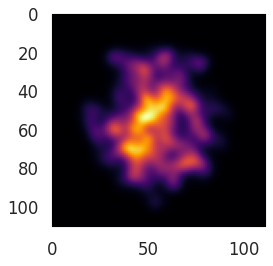

In [8]:
i=np.random.randint(1, high=n_profiles+1, size=1, dtype='l')[0]
plt.imshow(trainX[i], cmap='inferno')
plt.tight_layout(True)
plt.show()

The cell below plots a histogram of the values of all pixels in the training data. 
We can see that there are very few cells with large energy density.

Perhaps a nonlinear rescaling function could make the distribution less skewed. 

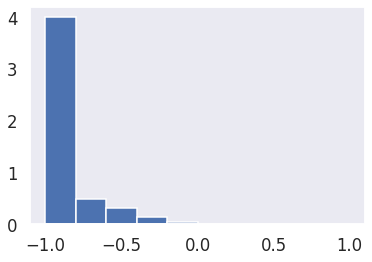

In [9]:
pixel_vals = trainX.flatten()
plt.hist(pixel_vals, density=True)
plt.show()

In [10]:
#constructing the WGAN, see wgan.py to change settings/structure
my_gan = WGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 29, 29, 32)       

In [11]:
#training of the WGAN
train_gan = False
if train_gan:
    my_gan.train(X_train=trainX, epochs=2000, batch_size=32, sample_interval=50)

In [12]:
#load the WGAN from disk to make predictions
from keras.models import load_model
def load_predict_profiles(epoch=1000, n_samples=1):
    model = load_model('generators/generator_model_'+str(epoch)+'.h5')
    noise = np.random.normal(0, 1, (n_samples, 100))
    gen_imgs = model.predict(noise)
    smooth_imgs = np.array([filters.gaussian(img, sigma=2, preserve_range=True) for img in gen_imgs])
    return smooth_imgs

/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  import sys


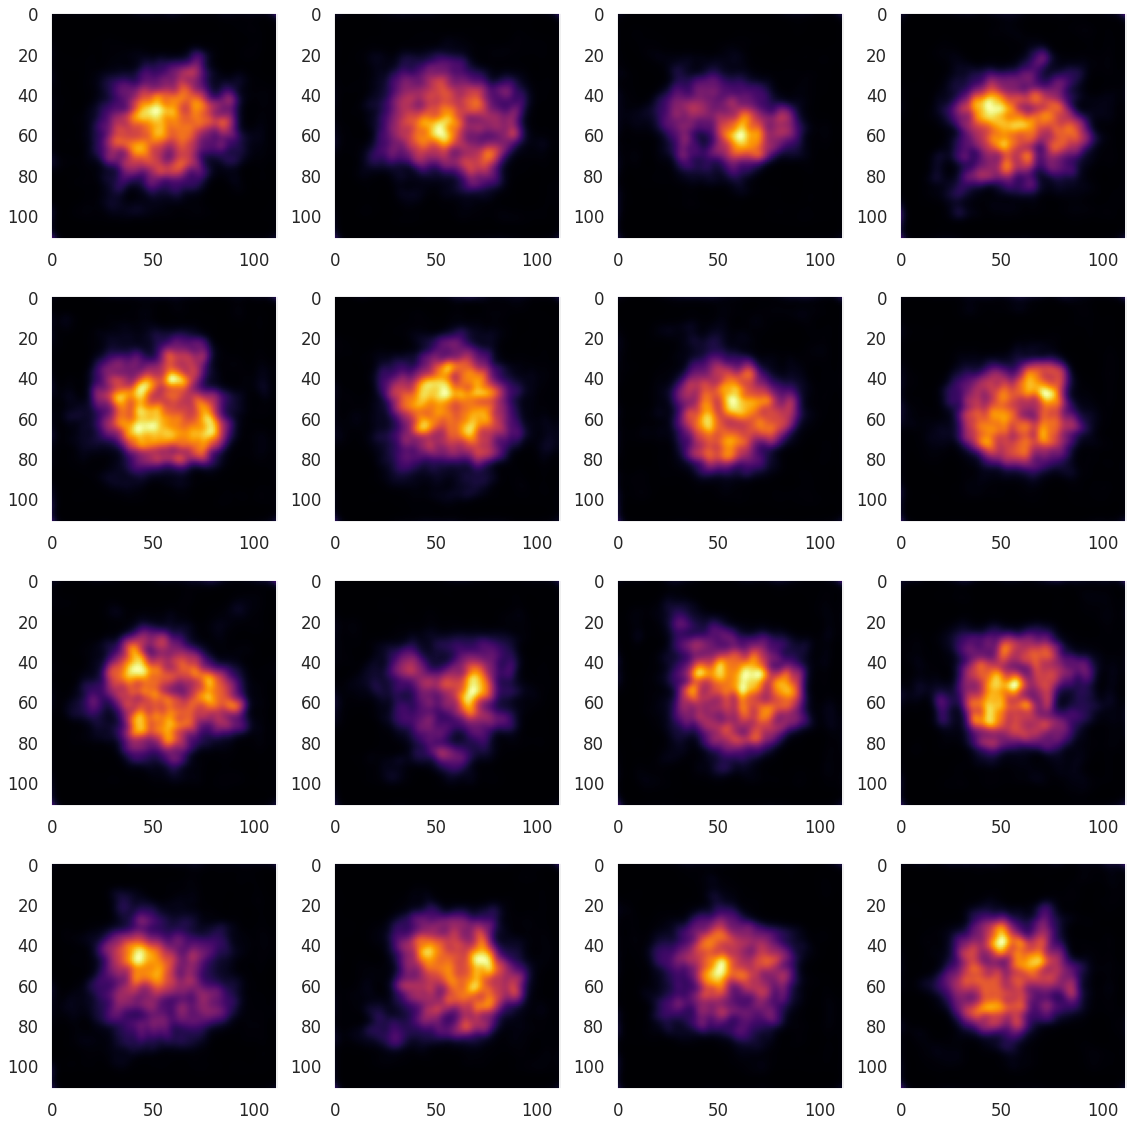

In [13]:
nrows = ncols = 4
eps = load_predict_profiles(epoch=1000, n_samples=nrows*ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*nrows,4*ncols))
for iax, ax in enumerate(axes.flatten()):
    ax.imshow(eps[iax, :, :, 0], cmap='inferno')
    
plt.tight_layout(True)
plt.show()

The cell below defines a fast (cythonized) method to calculate the eccentricities, a set of angular moments, of energy density profiles.

In [14]:
%%cython

import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from libc.math cimport fabs
from libc.math cimport cos
from libc.math cimport sin
from libc.math cimport atan2

DTYPE = np.float
ctypedef np.float_t DTYPE_t
cdef int N_x = 112 #size of image in x
cdef int N_y = 112 #size of image in y

# a function to compute the radius
cpdef r_func(int ix, int iy, float dx, float dy, float n):
    cdef float x, y, r
    x=dx*(2.*ix-N_x)/2.
    y=dy*(2.*iy-N_y)/2.
    r = sqrt(x*x + y*y)
    return r**n

# a function to compute the phase angle phi
cpdef cos_phi_func(int ix, int iy, float dx, float dy, float n):
    cdef float x, y, phi, real, imag
    x=dx*(2.*ix-N_x)/2.
    y=dy*(2.*iy-N_y)/2.
    phi = atan2(y, x)
    return cos(n*phi) 

cpdef sin_phi_func(int ix, int iy, float dx, float dy, float n):
    cdef float x, y, phi, real, imag
    x=dx*(2.*ix-N_x)/2.
    y=dy*(2.*iy-N_y)/2.
    phi = atan2(y, x)
    return sin(n*phi) 

# this function computes |eps_n|, where 
# eps_n = \int dx dy e(x, y) r^2 exp(i*n*phi) / \int dx dy e(x, y) r^2 
cpdef calc_ecc(e, float dx, float dy):    
    
    cdef int n_harmonic = 5
    cdef np.ndarray eps = np.zeros((n_harmonic), dtype=DTYPE)
    
    cdef np.ndarray r_mat = np.zeros_like(e, dtype=DTYPE)
    cdef np.ndarray cos_phi_mat = np.zeros_like(e, dtype=DTYPE)
    cdef np.ndarray sin_phi_mat = np.zeros_like(e, dtype=DTYPE)
    
    cdef float norm 
    
    for n in range(n_harmonic):
        n_f = <float>n
        r_mat = np.array([[ r_func(ix, iy, dx, dy, n_f) for iy in range(N_y) ] for ix in range(N_x) ])
        cos_phi_mat = np.array([[ cos_phi_func(ix, iy, dx, dy, n_f) for iy in range(N_y) ] for ix in range(N_x) ])
        sin_phi_mat = np.array([[ sin_phi_func(ix, iy, dx, dy, n_f) for iy in range(N_y) ] for ix in range(N_x) ])
        eps[n] =  np.sqrt( np.sum( e * cos_phi_mat * r_mat )**2. +  np.sum( e * sin_phi_mat * r_mat )**2. )
        norm = np.sum( e * r_mat)
        #print(norm)
        eps[n] /= norm

    
    return eps

The energy weighted eccentricities become ill defined when $\epsilon \rightarrow 0$, which is the case after we have rescaled all the profiles. 

So before computing the eccentricities, we will undo these transformations.

In [26]:
n_samples = 2000

In [27]:
trainX = inv_global_scaler(trainX, eps_max)

In [28]:
#compute the eccentricities of the training profiles
ecc_true = np.array([calc_ecc(e, dx, dy) for e in trainX[:n_samples,:,:]])

We can calculate the eccentricities predicted by the generator as it existed in various epochs during its training. 

In [29]:
#sample n_samples predicted profiles from the WGAN and compute their eccentricities
eps = load_predict_profiles(epoch=1000, n_samples=n_samples)

#undo the scaling 
eps = inv_global_scaler(eps, eps_max)

#the distributions of eccentrities predicted by the GAN
ecc_pred = np.array([calc_ecc(e, dx, dy) for e in eps])

/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


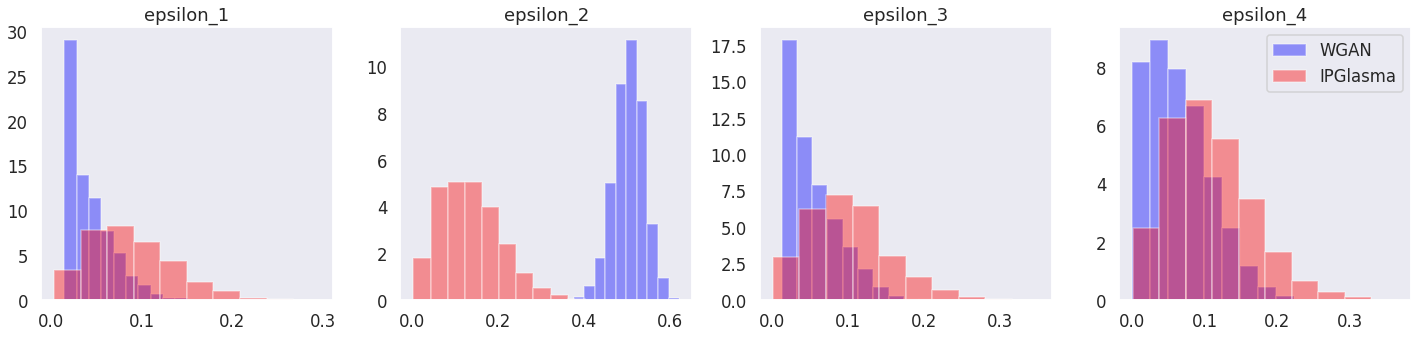

In [30]:
n_harmonic = 4
fig, axes = plt.subplots(1, n_harmonic, figsize=(5*n_harmonic, 5))
for n, ax in enumerate(axes.flatten()):
    ax.hist(ecc_pred[:, n+1], alpha=0.4, color='blue', label='WGAN', density=True)
    ax.hist(ecc_true[:, n+1], alpha=0.4, color='red', label='IPGlasma', density=True)
    ax.set_title('epsilon_'+str(n+1))
    #ax.set_xlim([0., 0.4])
    
plt.legend()
plt.tight_layout(True)
plt.show()

In [31]:
#sample n_samples predicted profiles from the WGAN and compute their eccentricities
eps = load_predict_profiles(epoch=2000, n_samples=n_samples)

#undo the scaling 
eps = inv_global_scaler(eps, eps_max)

#the distributions of eccentrities predicted by the GAN
ecc_pred = np.array([calc_ecc(e, dx, dy) for e in eps])

/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


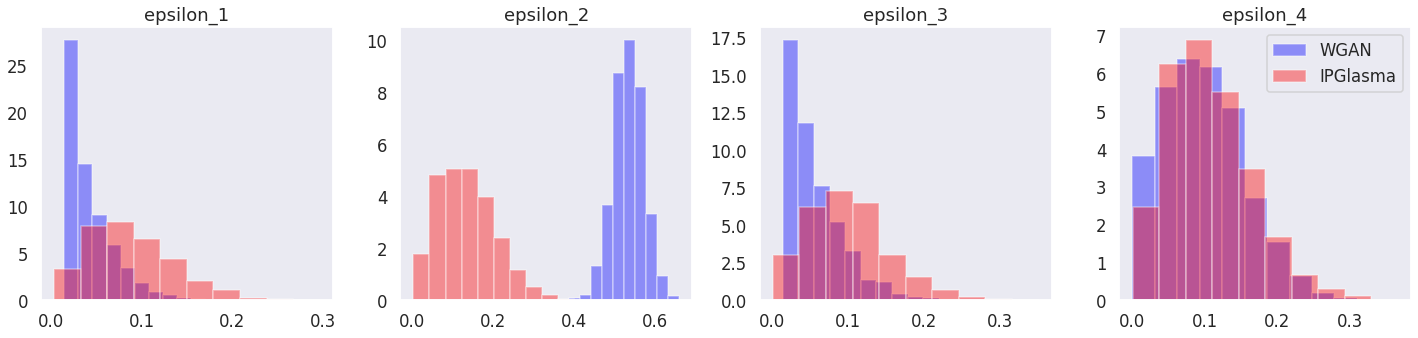

In [32]:
n_harmonic = 4
fig, axes = plt.subplots(1, n_harmonic, figsize=(5*n_harmonic, 5))
for n, ax in enumerate(axes.flatten()):
    ax.hist(ecc_pred[:, n+1], alpha=0.4, color='blue', label='WGAN', density=True)
    ax.hist(ecc_true[:, n+1], alpha=0.4, color='red', label='IPGlasma', density=True)
    ax.set_title('epsilon_'+str(n+1))
    #ax.set_xlim([0., 0.3])
    
plt.legend()
plt.tight_layout(True)
plt.show()

In [21]:
# a function to load the pre-calculated eccentricities from disk
header_list = ['t', 'e1', 'psi1', 'e2', 'psi2', 'e3', 'psi3', 'e4', 'psi4', 'e5', 'psi5',
              'e6', 'psi6', 'cutoff', 'sqrtAv', 'maxX', 'maxY', 'b', 'Tpp', 'something'] 
def load_ipglasma_ecc(i, cent_str='0-10'):
    """A function to read in a single ipglasma eccentrities from disk. 
    By default cent_str='0-10' loads training events from the 0-10% most
    central events."""
    df = pd.read_csv('training_profiles/PbPb'+cent_str+'/eccentricities'+str(i)+'.dat', header=None, 
                 sep=' ', names=header_list, index_col=None)
    return df

In [22]:
df = load_ipglasma_ecc(1).iloc[[-1]]
for i in range(2, n_samples+1):
    df_new = load_ipglasma_ecc(i).iloc[[-1]]
    df = df.append(df_new, ignore_index=True)

/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


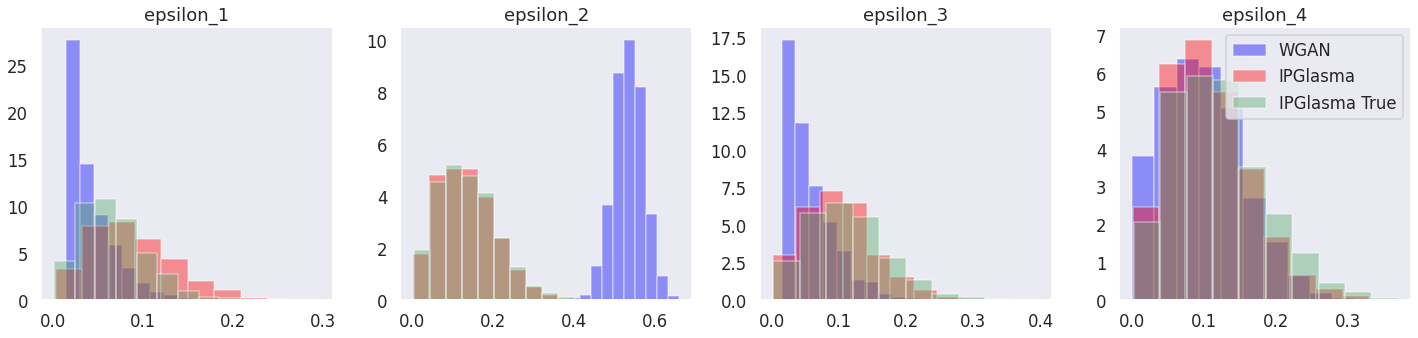

In [33]:
n_harmonic = 4
fig, axes = plt.subplots(1, n_harmonic, figsize=(5*n_harmonic, 5))
for n, ax in enumerate(axes.flatten()):
    ax.hist(ecc_pred[:, n+1], alpha=0.4, color='blue', label='WGAN', density=True)
    ax.hist(ecc_true[:, n+1], alpha=0.4, color='red', label='IPGlasma', density=True)
    ax.hist(df['e'+str(n+1)], alpha=0.4, color='g', label='IPGlasma True', density=True)
    ax.set_title('epsilon_'+str(n+1))
    
plt.legend()
plt.tight_layout(True)
plt.show()